# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




# Setup

In [ ]:
# fixes some random encoding errors
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# So that the generated outputs wrap around
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
!nvidia-smi

Sun Mar 19 20:20:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |   8153MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

KAO transcripts

In [ ]:
# mount my Google Drive directory /and access the training data located there
gdrive_dir = '/content/gdrive/'
data_path = 'gdrive/MyDrive/GPT2test/'

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/gdrive/


In [ ]:
df = pd.read_csv(f'{data_path}transcript_data/kaorpus.csv')
df.dropna(subset=['Text'], inplace=True)
df

,Text
0,A question from Brandon. So just out of curios...
1,A second challenge is that features of the res...
2,"Actually, it's weird to see. We have really go..."
3,"again. Okay, so, uh, Wingshee, your question w..."
4,"again. Okay, so, uh, Wingshee, your question w..."
...,...
518,You may feel the pace of the class is somewhat...
519,You may feel the pace of the class is somewhat...
520,You may feel the pace of the class is somewhat...
521,You would have the access to going from zero t...


In [ ]:
print(np.median([len(d) for d in df.Text]))
print(np.max([len(d) for d in df.Text]))

# the c147 transcripts are way longer than the other rows so we split it into ~1000 character rows
data = list()
for d in df.Text:
  if len(d) < 2000:
    data.append(d)
  else:
    d =  [e+'.' for e in d.split('.') if e]
    for i in range(len(d) // 10):
      data.append("".join(d[i: min(i + 10, len(d))]))
    

897.0
32767


In [ ]:
np.max([len(d) for d in data])

2289

There are at most 2289 characters per row, so this is good

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

<ipython-input-51-cb8db075aad6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

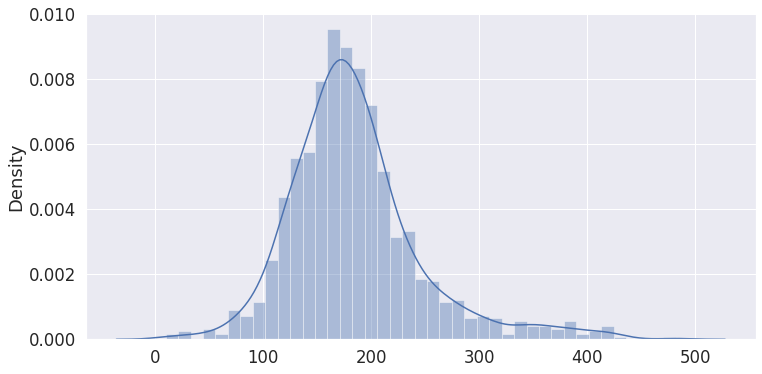

In [ ]:
doc_lengths = []

for d in data:

    # get rough token count distribution
    tokens = nltk.word_tokenize(d)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
count = 0
sns.distplot(doc_lengths)

In [ ]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [ ]:
np.average(doc_lengths)

184.73252562907734

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that all rows will fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

In [ ]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium
tokenizer.add_tokens(['<|answer|>']) # for question and answer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [ ]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each row in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(data, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  965 training samples
  108 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4 # turn this down when finetuning on the QA dataset so it doesn't overfit and mess up the QA capabilities that much
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 500

params = {
    'epochs': epochs,
    'lr': learning_rate,
    'warmup_steps': warmup_steps,
    'eps': epsilon,
    'sample_every': sample_every
}

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
# load a saved model. Change the model path 
MODEL_PATH = f'{data_path}model_save/gpt2-base3.pt'

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
# training loop
from tqdm import tqdm
MODEL_PATH = f'{data_path}model_save/gpt2-base3.pt'

total_t0 = time.time()

training_stats = []

model = model.to(device)

try:
  checkpoint = torch.load(MODEL_PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
except:
  epoch = 0

for epoch_i in range(epoch, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, #you're basically training the model to be able to output your inputs
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

            # Create output directory if needed
            if not os.path.exists(f"{data_path}/model_save"):
                os.makedirs(f"{data_path}/model_save")

            print("Saving model to %s" % MODEL_PATH)

            torch.save({
              'epoch': epoch_i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss,
            }, MODEL_PATH)

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


100%|██████████| 483/483 [04:10<00:00,  1.93it/s]



  Average training loss: 1.54
  Training epoch took: 0:04:11

Running Validation...
  Validation Loss: 0.68
  Validation took: 0:00:09

======== Epoch 2 / 5 ========
Training...


 63%|██████▎   | 302/483 [02:33<01:31,  1.97it/s]

In [ ]:
# save the model if you want it
if not os.path.exists(f"{data_path}/model_save"):
    os.makedirs(f"{data_path}/model_save")

print("Saving model to %s" % MODEL_PATH)

torch.save({
  'epoch': 5,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'loss': loss,
  'params': params
}, MODEL_PATH)

Saving model to gdrive/MyDrive/GPT2test/model_save/gpt2-qa+ft1.pt


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.52,0.73,0:04:08,0:00:09
2,0.62,0.50,0:04:07,0:00:09
3,0.44,0.41,0:04:08,0:00:09
4,0.35,0.39,0:04:07,0:00:09
5,0.31,0.39,0:04:08,0:00:09


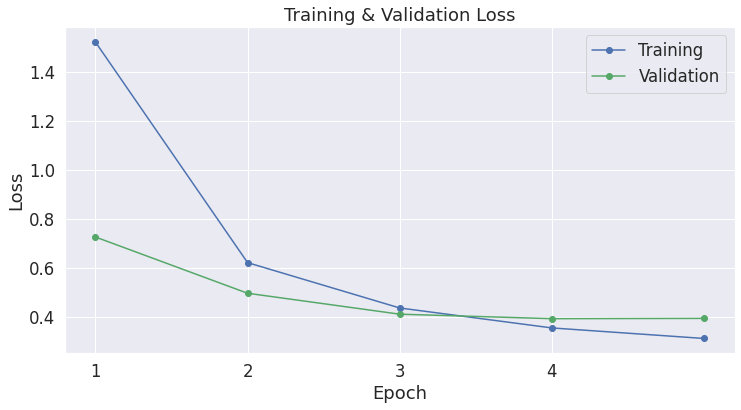

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50260, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Generate Text

In [ ]:
def predict(model, tokenizer, prompt, qa = False):
    model.eval()
    prompt = "<|startoftext|>" + prompt
    if qa:
      prompt += "<|answer|>"

    inputs = tokenizer(prompt, return_tensors="pt")

    sample_outputs = model.generate(
                                    **inputs, 
                                    #bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    # top_k=50, 
                                    max_length = len(inputs['input_ids'][0]) + 50,
                                    top_p=0.90, 
                                    num_return_sequences=3
                                    )

    for i, sample_output in enumerate(sample_outputs):
        print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

## GPT-base Results

In [ ]:
predict(model, tokenizer, "One of the reasons to prefer small kernel sizes over larger ones is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: One of the reasons to prefer small kernel sizes over larger ones is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs? The first is that you don't have to do extra computation and you don't have to deal with batch normalization and the propagation of neural networks. You don't have to do extra computation and you can


1: One of the reasons to prefer small kernel sizes over larger ones is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs? Yes. The more room you have, the more room you have in your code to train neural networks. Also, you don't have to do extra comp

In [ ]:
predict(model, tokenizer, "Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and capture temporal dependencies, making them well-suited for tasks such as language modeling, speech recognition, and music generation. Which use cases do we see RNNs preferred over CNNs?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and capture temporal dependencies, making them well-suited for tasks such as language modeling, speech recognition, and music generation. Which use cases do we see RNNs preferred over CNNs? Here, let me go ahead and recap what we're going to do. We're going to go over the pros and cons of each of these architectures.


1: Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and c

In [ ]:
predict(model, tokenizer, "The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classification, object detection, and semantic segmentation. In fact, ResNet achieved state-of-the-art performance on the challenging ImageNet dataset, reducing the error rate by a significant margin compared to previous approaches. Why was ResNet such a big breakthrough in computer vision?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classification, object detection, and semantic segmentation. In fact, ResNet achieved state-of-the-art performance on the challenging ImageNet dataset, reducing the error rate by a significant margin compared to previous approaches. Why was ResNet such a big breakthrough in computer vision? Because before we begin, we have to understand how our eyes work. We have to be able to perceive the movement of a robotic arm. We have to be able to make movements based on the movements we make. And that includes both our eye movements


1: The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classification, object detection, and sema

In [ ]:
predict(model, tokenizer, "All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research. So today, I'm going to talk about a common filter whose behavior is essentially the same as that of the Fourier transform with respect to period. Right. And we have, in the lectures, done the Fourier transform example where we had the


1: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research. And then the motivation of why we can't use late days on the projects is because they're not totally reliable. So at the end of the day, we're going to be using VAEs and we're not going to have to deal with the


2: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem tha

In [ ]:
predict(model, tokenizer, "And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood. And then I'm going to take this expression and I'm going to take my model code and I'm going to derive it for this probability. And then what that means is that if I have a distribution, where I have a probability of x given


1: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood. So let's say that the xk given xk is a probability distribution with k minus 1. And that we know from our definition of a probability distribution that this k is a product of the probability of xk given xk and that it's


2: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we

In [ ]:
predict(model, tokenizer, "Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values. And so for the HFT that we're going to want to be able to have the spectrum and frequency response in that case, we would need a constant of some sigma. So this would be that signal that is going to be a sigma


1: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values. And then we could say that the depth should be 6,000,000 or something. So I'm confused. Yeah, actually, what would it be if we had a 2D block where we have 100 of these nodes? And I'm wondering


2: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values. I would need to take the time to consider that. And then I'm going to pause the video for one second and then I'm going to derive the neural data that we need for this model. So in the first

In [ ]:
predict(model, tokenizer, "This cat is very cute and")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: This cat is very cute and he's in a good <|answer|>  correct, yeah. The correct question is he's in the correct number three, the correct number four, etc. But I think that's a bit too fast. Okay.


1: This cat is very cute and he is my absolute favorite. I cat boy will be your instructor for this course and on behalf of all of you in this class, we will strive to release any questions that we may have on the project using Python. With that said,


2: This cat is very cute and you all know that she is interested in learning. You can do that for her question and answer, etc. But we won't take any verbal questions from the homework. We just asked if she'd like to ask a question for the homework. I




In [ ]:
predict(model, tokenizer, "In a world where machines had emotions")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: In a world where machines had emotions and whatnot, what we want to do is we want to tell a story. And so if we want to tell a complex exponential, what we want to tell are these complex exponential s that we said are the points in time when the spikes occurred


1: In a world where machines had emotions and not brains, there would be these neural spikes that are called kinematics. And what these spikes look like is they are moving in time. And they have no spikes. And the spikes look like if you were to move your arm over a


2: In a world where machines had emotions like fear, it would be hard to imagine <|answer|>  rest of the <|answer|> <|answer|>  class being completely paralyzed by a computer cursor on the screen. And then in this hypothetical world, instead of being paralyzed, we would be doing tasks where the computer cursor




In [ ]:
predict(model, tokenizer, "The universe is a vast and mysterious place, full of wonders and secrets")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: The universe is a vast and mysterious place, full of wonders and secrets, and <|answer|>  answer to these questions is yes. So I'm going to provide this information for you to write to me, copy and paste to your computer, and so that you can have a fully connected internet connection to the ISS. All right.


1: The universe is a vast and mysterious place, full of wonders and secrets. exact same exact thing as our sun system. All right. But, for the rest of the series, where does the name, or does it have the same meaning as a sun system that we have from ancient times


2: The universe is a vast and mysterious place, full of wonders and secrets. <|answer|>  mystery. Okay. So why is it that we only have the last part of the class saying we have the last part of the class saying we have the last part of the class saying we have the last part of




## Using fine-tuned GPT (QA + FT)

In [ ]:
predict(model, tokenizer, "One of the reasons to prefer small kernel sizes over larger is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs?", qa = True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: One of the reasons to prefer small kernel sizes over larger is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs? <|answer|>  faster training


1: One of the reasons to prefer small kernel sizes over larger is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What are the benefits of using smaller kernel sizes in CNNs? <|answer|> Boeing more properties.


2: One of the reasons to prefer small kernel sizes over larger is that smaller kernels have fewer parameters than larger ones, which can reduce the model's complexity and computational requirements. This can lead to faster training times and lower memory requirements. What

In [ ]:
predict(model, tokenizer, "Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and capture temporal dependencies, making them well-suited for tasks such as language modeling, speech recognition, and music generation. Which use cases do we see RNNs preferred over CNNs?", qa = True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and capture temporal dependencies, making them well-suited for tasks such as language modeling, speech recognition, and music generation. Which use cases do we see RNNs preferred over CNNs? <|answer|> time-learning


1: Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) are two popular types of deep learning models that are used in different domains. RNNs are generally preferred over CNNs for processing sequential data, such as time-series data, speech, and text. This is because RNNs can process input data of varying lengths and capture temporal dependencies, making them well-suited for tasks such as language modeling, speech recogn

In [ ]:
predict(model, tokenizer, "The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classification, object detection, and semantic segmentation. In fact, ResNet achieved state-of-the-art performance on the challenging ImageNet dataset, reducing the error rate by a significant margin compared to previous approaches. Why was ResNet such a big breakthrough in computer vision?" qa=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classification, object detection, and semantic segmentation. In fact, ResNet achieved state-of-the-art performance on the challenging ImageNet dataset, reducing the error rate by a significant margin compared to previous approaches. Why was ResNet such a big breakthrough in computer vision? It also helped to introduce the loss ofness at least? You're under the So You can do this for every single class or in a different room. So, the amount of noise in the essentially anonymous room here is very important. All right, so instead of an object's performance.


1: The introduction of residual connections in ResNet led to much deeper networks being trained than previously possible. This allowed for much better performance on difficult computer vision tasks, such as image classificat

In [ ]:
predict(model, tokenizer, "All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research. All right. And the question is, why do we do like to have our two parts being equal to one. Yeah, what we do is we're going to talk about for now? A, you're going to be equal to the change that we do


1: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk about for the rest of this class, which is going to be related to my research. All right. I'm just going to get there a little bit about the phase change and what we would do is the change that we would take on the, I see the Fourier transform of the class. And we're going to change the distribution of the


2: All right. All right, cool. Today, we'll just talk about the structure of this class and then introduce the problem that we'll talk abou

In [ ]:
predict(model, tokenizer, "And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood. That would be true. We're going to try to use a spike spike like when it's going to be the spike that will make it the spike in every single spike. And so last lecture, we had talked about how this process would have


1: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're going to actually write out what this means in terms of our models that we can derive our likelihood. We can take the number of questions, which is one more thing here. So the number of questions in this class. The number of questions that can be answered in this class is going to be over. And then when I can tell you what


2: And okay, let's move on for now. So what we're gonna do is I'm going to take this expression over here. And we're g

In [ ]:
predict(model, tokenizer, "Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values.")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values. And that's what I would do here is a summary of how we would do and the first factor is this expression here. So if I do the first factor, A is that the second factor is the probability that I'm going to move here. Yeah, that is, what I know that. Let me just do the second of my inputs


1: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB values. But when you look at the absolute infinite points of these terms, that's the absolute point of this impulse. Okay, so here, this will be the second unit. So in this case, the absolute point of this impulse is the absolute same as the absolute, i, that's this impulse. This is a function of the absolute potential of


2: Great, Yeah, So now another student is saying, in this case, would it make sense to match the depth because that's our RGB

In [ ]:
predict(model, tokenizer, "This cat is very cute and")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: This cat is very cute and fairly consistent And so in the past, we just won't take a bit of it Any questions on this or discussions I already have a Zoom? Alright The reason that I wanted to take the tools that I'm going to take the tools that I was planning to take, which is that I was planning to take the tools that I started to compute And I would want to highlight So I would cover up two co-dimensional neural networks, which is that each of these


1: This cat is very cute and then the cell is probably the act of planning this class And it's going to be a function of exponential and this also tells me I'll want to explain that if I take my head of an object and I will be able to know how to proceed this homework, I know that if I go ahead and I know that I'll tell me what I will do is I'm sorry. And I'll know that if I were to take my head of this class and


2: This cat is very cute and in general at least when you're only controlling the big dacastrony or a much larger axis an

In [ ]:
predict(model, tokenizer, "In a world where machines had emotions")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: In a world where machines had emotions, the monkey would be the controlling center of that, the monkey would be the center of what the monkey was thinking. That would be the baseline state. And the monkey would be instructed to plan to that baseline state until the next training phase when the monkey reaches to targets of zero mean and variance. All right. And then we said, and we talked about this idea, which is that we would train the monkey to plan to the next reach target, and then if he reaches to target of zero


1: In a world where machines had emotions and not just physical characteristics, how <|answer|>  brain works, it's a complex system where what we want to do is we want to build a system that can interface with, for example, light or sound signals, like the perception of what is happening on the screen or audio. And light or sound signals can be very helpful for this function because in a normal brain, light signals are attenuating. But if it's attenuating, the signal 

In [ ]:
predict(model, tokenizer, "The universe is a vast and mysterious place, full of wonders and secrets")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: The universe is a vast and mysterious place, full of wonders and secrets about how these plot models are implementing or meeting via reason of observation. So we're going to cover variational autoencoders, but we'll do some criminalization and neural networks, but the output of the electric field. And then we'll cover the neural network architecture. And we're also going to derive a way to this information that we're going to use to solve the problems for this class. And so we


1: The universe is a vast and mysterious place, full of wonders and secrets, so like the rest of the universe, they're very helpful in understanding that the world is a hope that's given them exposure to all wrongs and gets them to the world. All right. So the world reaches to the world, we know from a few things that had close relationships to the world. And so now we're going to take a few more details. The first is that that they are now thought to


2: The universe is a vast and mysterious place, full of